In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, classification_report, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from dmba import plotDecisionTree
from sklearn import preprocessing

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../data/drinking_water_potability.csv')
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# Data Exploration
-------

### Data imputation using iteractive imputer

In [4]:
# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Enable the iterative imputer
imputer = IterativeImputer()

# Train the imputer on the data with missing values
imputer.fit(df)

# Transform the data to impute missing values
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)

# Check for missing values after imputation
print("Missing values after imputation:")
print(df_imputed.isnull().sum())

Missing values after imputation:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<Axes: xlabel='Potability'>

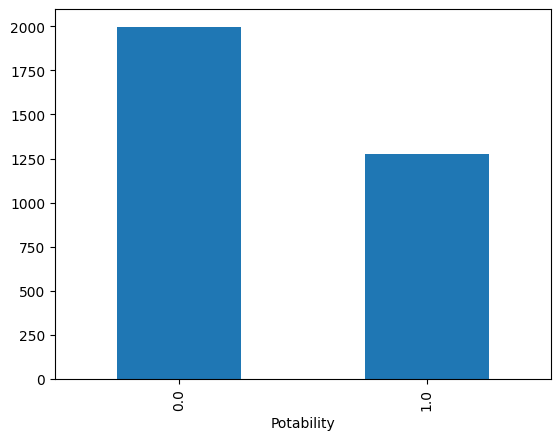

In [5]:
df_imputed['Potability'].value_counts().plot(kind='bar')

### Distribution of values for each characteristic.

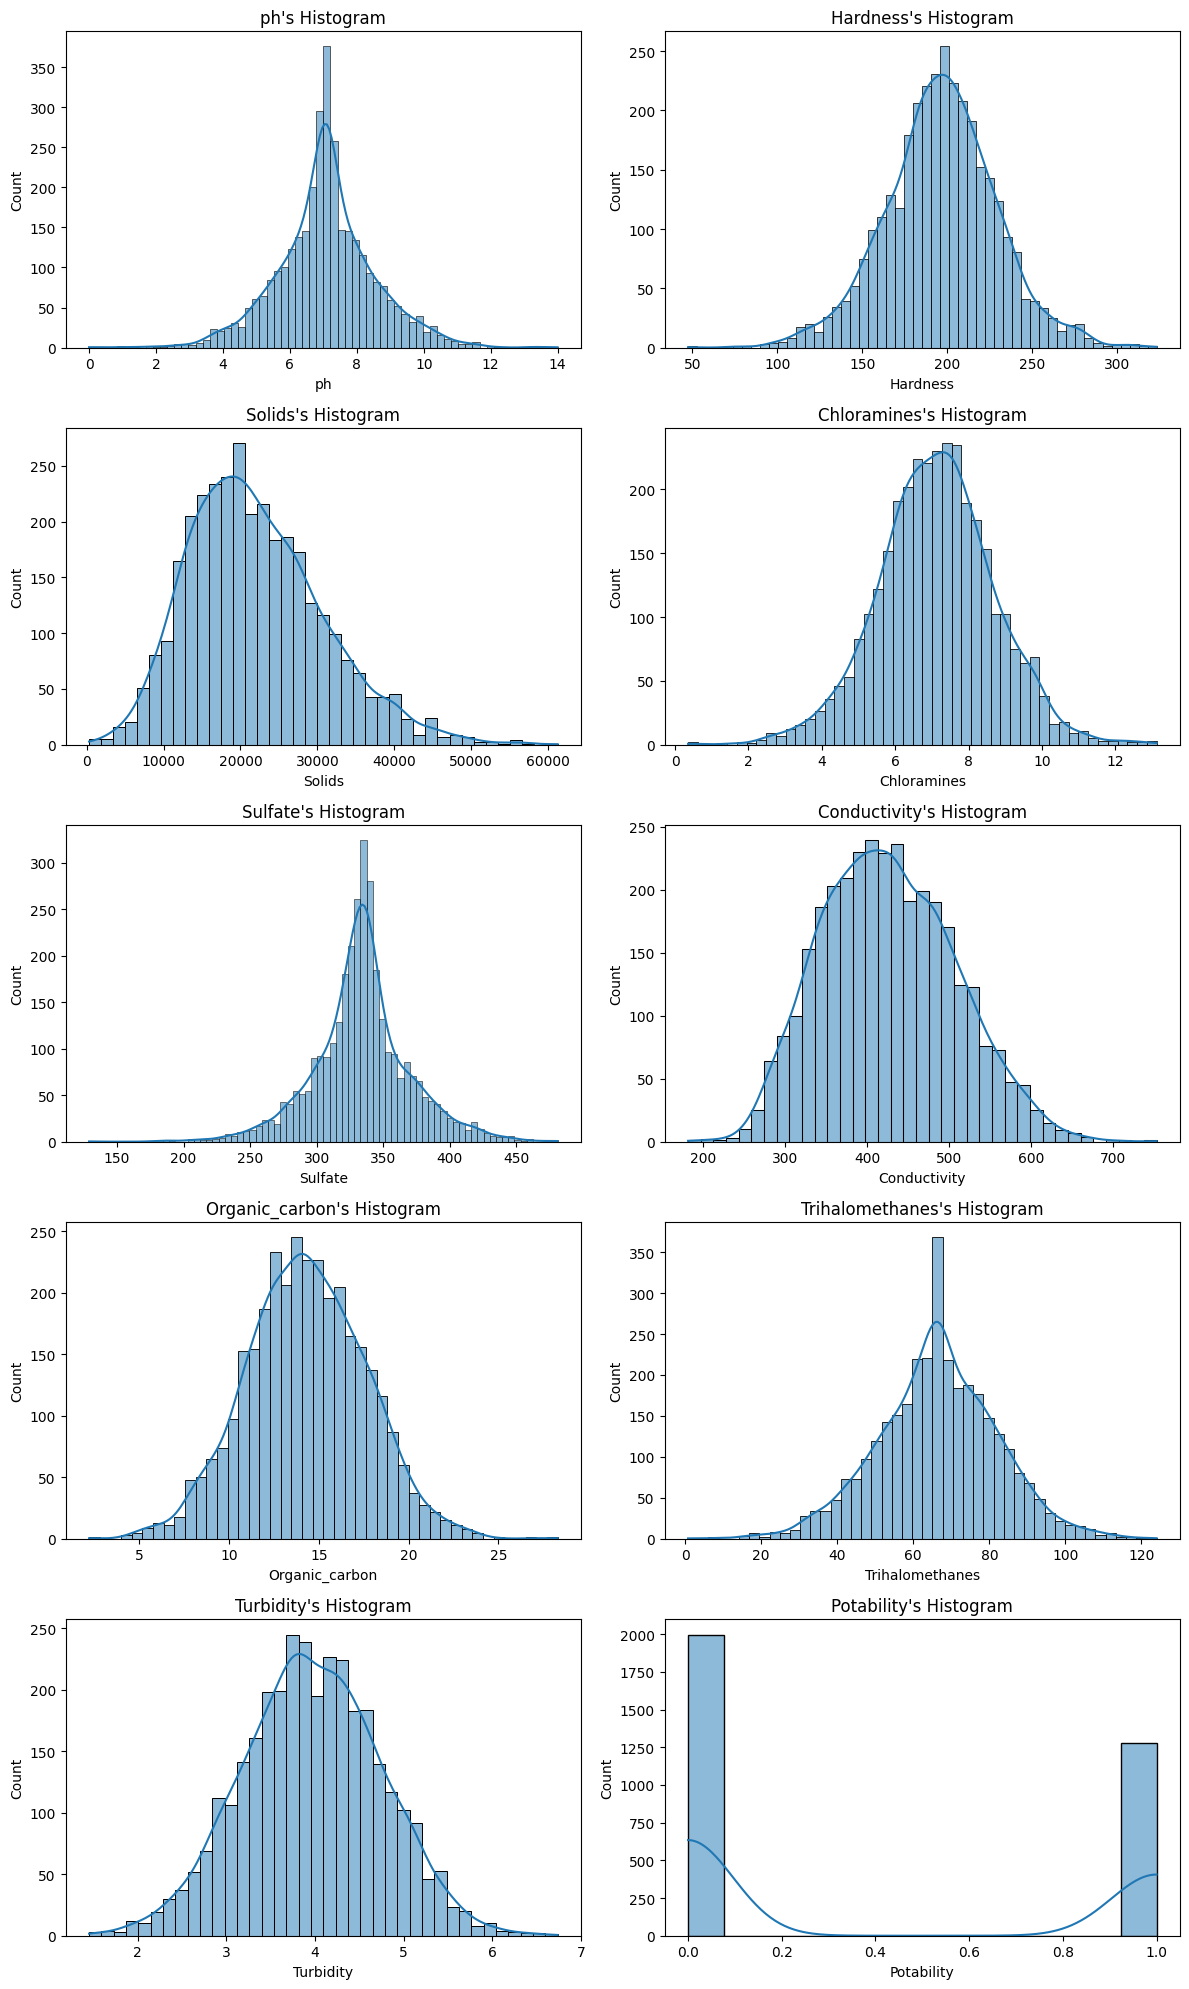

In [6]:
plt.figure(figsize=(12,20))

for n, column in enumerate(df_imputed.columns):
    plt.subplot(5, 2, n+1)
    sns.histplot(df_imputed[column], kde=True)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f"{column}'s Histogram")

plt.tight_layout()
plt.show()

### Outliers

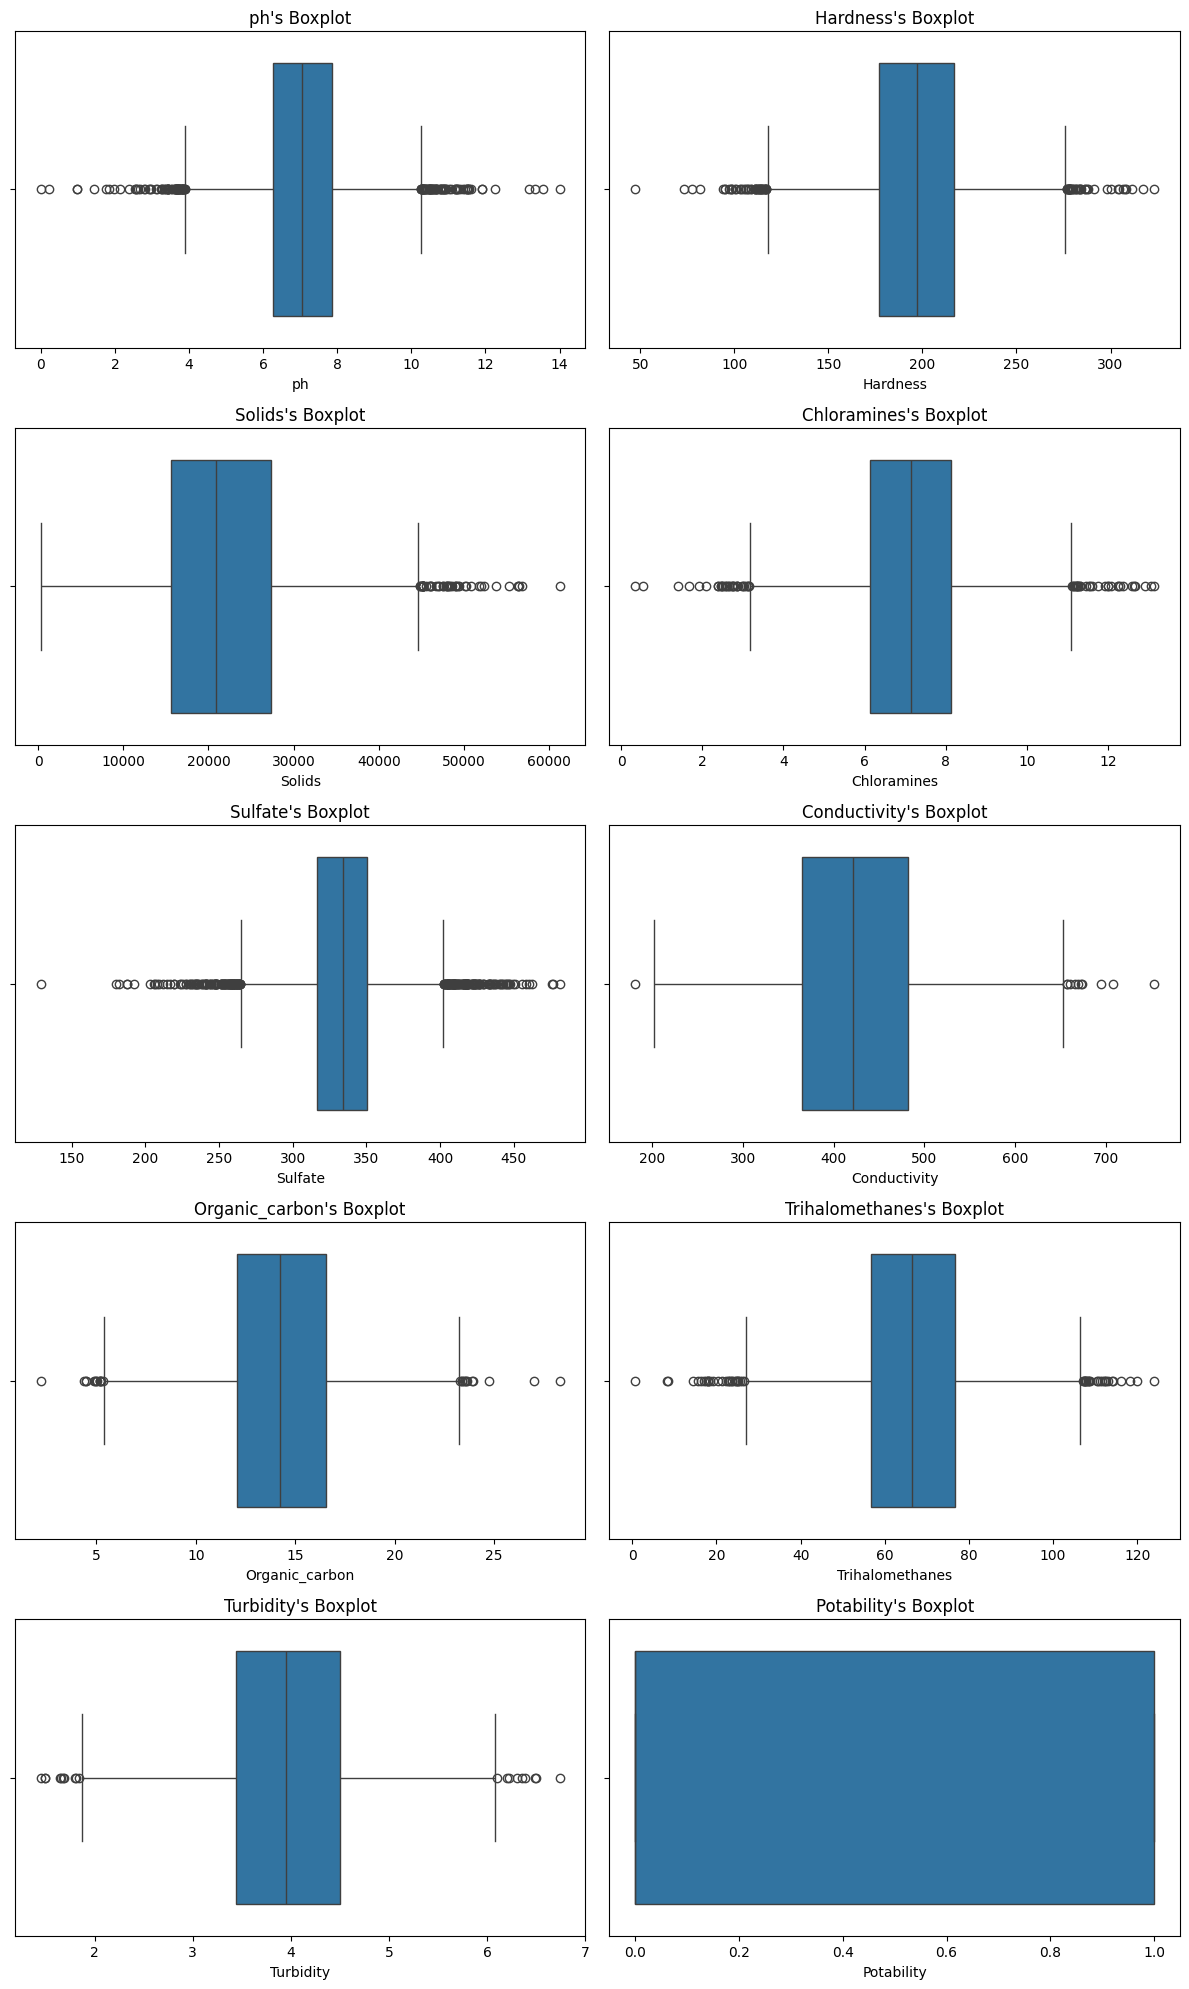

In [7]:
plt.figure(figsize=(12,20))

for n, column in enumerate(df_imputed.columns):
    plt.subplot(5, 2, n+1)
    sns.boxplot(x=df_imputed[column])
    plt.xlabel(column)
    plt.title(f"{column}'s Boxplot")

plt.tight_layout()
plt.show()

In [8]:
from sklearn.ensemble import IsolationForest

# Select only the numeric columns
numeric_columns = df_imputed.select_dtypes(include=['float64', 'int64'])

# Initialize and fit the Isolation Forest model
clf = IsolationForest(random_state=0)
clf.fit(numeric_columns)

# Identify outliers (1 for normal values, -1 for outliers)
outliers = clf.predict(numeric_columns)

# Filter only the normal (non-outlier) values
df_cleaned = df_imputed[outliers == 1]

### Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Select the numeric features
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the numeric features
numeric_columns_scaled = scaler.fit_transform(numeric_columns)

# Create a DataFrame with scaled features
df_scaled = pd.DataFrame(numeric_columns_scaled, columns=numeric_columns.columns)

### Data Balancing

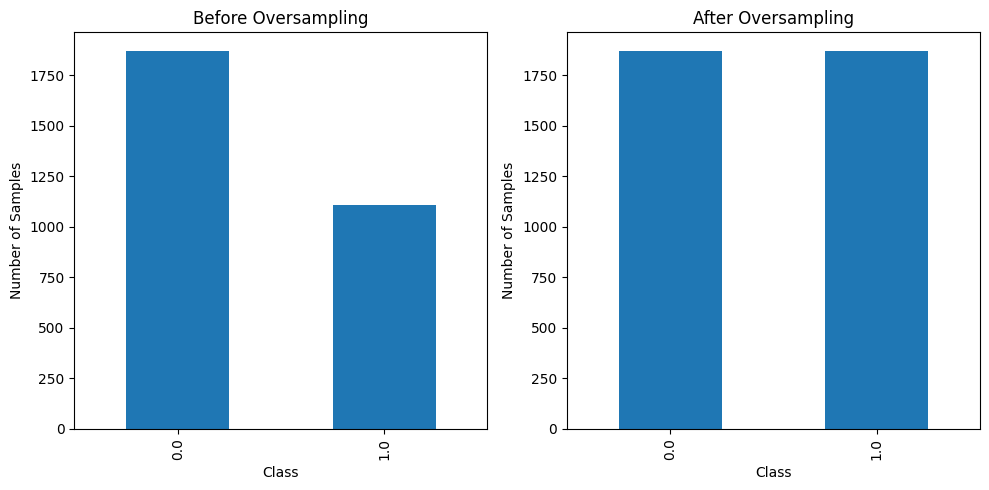

In [11]:
from imblearn.over_sampling import RandomOverSampler

# Select your features and the target variable
X = df_scaled.drop('Potability', axis=1)
y = df_scaled['Potability']

# Initialize the RandomOverSampler object
oversampler = RandomOverSampler(random_state=0)

# Apply oversampling to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

before_oversampling = y.value_counts()
after_oversampling = y_resampled.value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

before_oversampling.plot(kind='bar', ax=axs[0])
axs[0].set_title('Before Oversampling')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Samples')

after_oversampling.plot(kind='bar', ax=axs[1])
axs[1].set_title('After Oversampling')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Samples')

plt.tight_layout()

plt.show()


### Splitting of training and test data

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2992, 9)
X_test shape: (748, 9)


### Features importance

           feature  importance       std
0               ph    0.136261  0.018648
4          Sulfate    0.124779  0.017882
1         Hardness    0.117648  0.016951
2           Solids    0.109983  0.016483
3      Chloramines    0.109537  0.015649
6   Organic_carbon    0.104158  0.016129
5     Conductivity    0.102285  0.016605
8        Turbidity    0.097813  0.016421
7  Trihalomethanes    0.097536  0.016485


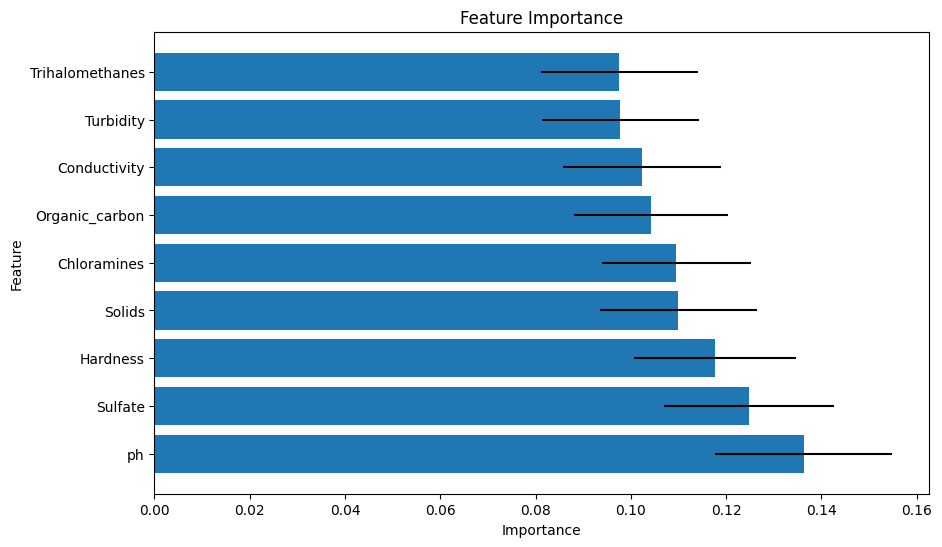

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=1000, random_state=2)

# Train the Random Forest classifier
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the standard deviation of feature importances across all trees
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a DataFrame with features and their importances
df_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(df_importances['feature'], df_importances['importance'], xerr=df_importances['std'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Select features with importance greater than or equal to 0.05
select_features = df_importances[df_importances.importance >= 0.05].feature

# Tuned DT

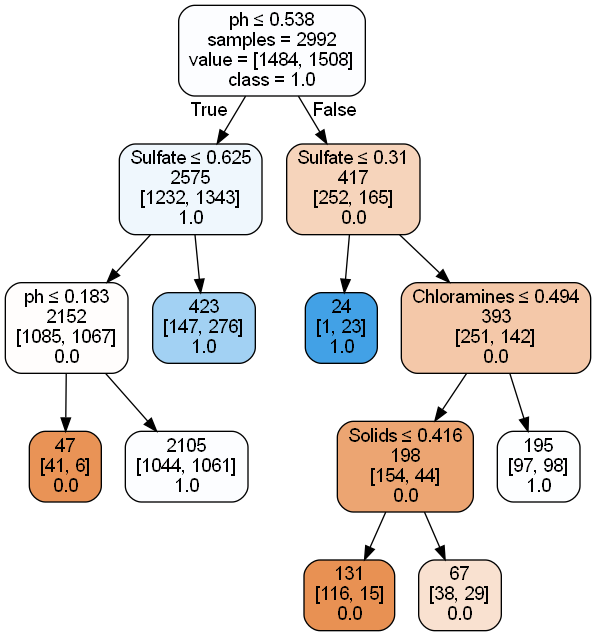

In [23]:
classTree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 120,
                                   min_impurity_decrease= 0.005, min_samples_split= 50, splitter= 'best')
classTree.fit(X_train, y_train)

plotDecisionTree(classTree, feature_names=X_train.columns, class_names=classTree.classes_)

In [24]:
y_predict_dt = classTree.predict(X_test)
dt_report = classification_report(y_test, y_predict_dt)
print(dt_report)

              precision    recall  f1-score   support

         0.0       0.67      0.08      0.15       386
         1.0       0.49      0.96      0.65       362

    accuracy                           0.51       748
   macro avg       0.58      0.52      0.40       748
weighted avg       0.58      0.51      0.39       748



# Tune MLP

## Tune MLP 1

In [28]:
cv = ShuffleSplit(n_splits=40, test_size=0.2, random_state=1)

param_grid = {
    'hidden_layer_sizes':[5],
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam'],
    'learning_rate':['constant','invscaling','adaptive']}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
y_predict_Tmlp = gridSearch.fit(X_train, y_train)

y_predict_Tmlp = gridSearch.predict(X_test)

Tmlp_report = classification_report(y_test, y_predict_Tmlp)

print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 40 folds for each of 36 candidates, totalling 1440 fits
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rat

In [29]:
print(Tmlp_report)

              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64       386
         1.0       0.61      0.59      0.60       362

    accuracy                           0.62       748
   macro avg       0.62      0.62      0.62       748
weighted avg       0.62      0.62      0.62       748



## Tune MLP 2

In [30]:
# Define the hyperparameter search space
param_grid = {
    'hidden_layer_sizes': [5, 10, 15, 20, 25, 30, (5, 5), (5, 10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate': ['invscaling']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    verbose=2
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Predict probabilities for positive class
y_pred_Tmlp2 = grid_search.predict_proba(X_test)[:, 1]

# Predict classes
y_predict_Tmlp2 = grid_search.predict(X_test)

# Generate classification report
Tmlp2_report = classification_report(y_test, y_predict_Tmlp2)

# Print results
print('Score: ', grid_search.best_score_)
print('Parameters: ', grid_search.best_params_)

Fitting 40 folds for each of 8 candidates, totalling 320 fits
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.8s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; tot

In [19]:
print(Tmlp2_report)

              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62       566
         1.0       0.61      0.63      0.62       556

    accuracy                           0.62      1122
   macro avg       0.62      0.62      0.62      1122
weighted avg       0.62      0.62      0.62      1122



## Tune MLP 3

In [20]:
param_grid = {
    'hidden_layer_sizes':[5,10,15,(5,5),(5,10)],
    'activation': ['identity'],
    'solver': ['adam'],
    'alpha': [0,0.0005,0.0001,0.0005,0.001],
    'learning_rate':['invscaling'],
    'learning_rate_init': [0,0.0001,0.0005,0.001, 0.005,0.01],
    'max_iter': [200,500],
    'shuffle': [True,False] 
}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring='recall',verbose=2)
y_predict_Tmlp3 = gridSearch.fit(X_train, y_train)

y_predict_Tmlp3 = grid_search.predict(X_test)

Tmlp3_report = classification_report(y_test, y_predict_Tmlp3)

print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 600 candidates, totalling 600 fits
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=200, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=200, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=500, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=500, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0.0001, max_iter=200, shuffle=True, solver=adam; total time=   0.8s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling

In [21]:
print(Tmlp3_report)

              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62       566
         1.0       0.61      0.63      0.62       556

    accuracy                           0.62      1122
   macro avg       0.62      0.62      0.62      1122
weighted avg       0.62      0.62      0.62      1122



# Random Forest

In [45]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
models = [RF]

train_acc = []
test_acc = []
train_logloss = []
test_logloss = []
train_rocauc = []
test_rocauc = []

In [47]:
for model in models:
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    train_acc.append(round(accuracy_score(y_train, y_train_hat)*100, 2))
    test_acc.append(round(accuracy_score(y_test, y_test_hat)*100, 2))
    train_logloss.append(log_loss(y_train, y_train_hat))
    test_logloss.append(log_loss(y_test, y_test_hat))
    train_rocauc.append(round(roc_auc_score(y_train, y_train_hat), 2))
    test_rocauc.append(round(roc_auc_score(y_test, y_test_hat), 2))

In [49]:
metrics = pd.DataFrame({'Train Accuracy %': train_acc, 'Test Accuracy %': test_acc, 'Train Log Loss': train_logloss,
                       'Test Log Loss': test_logloss, 'Train ROC AUC': train_rocauc, 'Test ROC AUC': test_rocauc}, 
                   index=['Random Forest'])
metrics

,Train Accuracy %,Test Accuracy %,Train Log Loss,Test Log Loss,Train ROC AUC,Test ROC AUC
Random Forest,100.0,79.14,2.220446e-16,7.517126,1.0,0.79


## Tuning

In [50]:
# Especificar hiperparametros del grid

n_estimators = list(range(200, 2000, 200))
max_depth = list(range(10, 110, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

param_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [51]:
# Entrenamiento de búsqueda aleatoria: aquí se probarán 100 parámetros diferentes con K-Fold de 3, lo que equivale a 300 iteraciones en total.

RF_random = RandomizedSearchCV(estimator = RF, param_distributions = param_grid, 
                               n_iter = 5, cv = 3, verbose=0, random_state=2002, n_jobs = -1)

RF_random.fit(X_train, y_train)

print(RF_random.best_params_)

{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


In [52]:
# Ahora, utilizando los mejores parámetros encontrados en la búsqueda aleatoria, compararemos su rendimiento con el primer modelo.

RF = RandomForestClassifier(n_estimators=1200, min_samples_split=5, min_samples_leaf=5, max_depth=50, bootstrap=True)
RF.fit(X_train, y_train)

y_train_hat = RF.predict(X_train)
y_test_hat = RF.predict(X_test)

train_acc.append(round(accuracy_score(y_train, y_train_hat)*100, 2))
test_acc.append(round(accuracy_score(y_test, y_test_hat)*100, 2))
train_logloss.append(log_loss(y_train, y_train_hat))
test_logloss.append(log_loss(y_test, y_test_hat))
train_rocauc.append(round(roc_auc_score(y_train, y_train_hat), 2))
test_rocauc.append(round(roc_auc_score(y_test, y_test_hat), 2))

metrics = pd.DataFrame({'Train Accuracy %': train_acc, 'Test Accuracy %': test_acc, 'Train Log Loss': train_logloss,
                       'Test Log Loss': test_logloss, 'Train ROC AUC': train_rocauc, 'Test ROC AUC': test_rocauc}, 
                   index=['Random Forest','Random Forest Tuned'])
metrics

,Train Accuracy %,Test Accuracy %,Train Log Loss,Test Log Loss,Train ROC AUC,Test ROC AUC
Random Forest,100.00,79.14,2.220446e-16,7.517126,1.00,0.79
Random Forest Tuned,98.83,77.54,4.216336e-01,8.095366,0.99,0.78


# **Resume:**

**Random Forest Tuning:**

* Precisión: 99.1% (para la clase 0)
* Recuperación: 72.35% (para la clase 1)
* Puntuación F1: 72.35%
* Exactitud: 72.35%

Los resultados muestran una alta precisión para la clase 0 y una recuperación razonable para la clase 1. Además, la exactitud general del modelo es del 72.35%, lo que indica un buen rendimiento general. Además, los resultados se mantienen estables después del ajuste de hiperparámetros.

**Random Forest:**

* Precisión: 100% (para la clase 0)
* Recuperación: 74.44% (para la clase 1)
* Puntuación F1: 74.44%
* Exactitud: 74.44%

Aunque este modelo muestra una precisión perfecta para la clase 0, la recuperación para la clase 1 es ligeramente menor que la del modelo ajustado, lo que sugiere un rendimiento ligeramente inferior.

**Tune MLP 3:**

* Precisión: 64% (para la clase 0)
* Recuperación: 63% (para la clase 1)
* Puntuación F1: 63%
* Exactitud: 63%

Este modelo tiene una precisión y recuperación razonables, pero su rendimiento general es menor en comparación con los modelos de Random Forest.

**Tune MLP 2:**

* Precisión: 64% (para la clase 0)
* Recuperación: 63% (para la clase 1)
* Puntuación F1: 63%
* Exactitud: 63%

Este modelo tiene resultados similares al Tune MLP 3, pero se coloca en una posición ligeramente inferior debido al orden.

**Tune MLP 1:**

* Precisión: 52% (para la clase 0)
* Recuperación: 52% (para la clase 1)
* Puntuación F1: 52%
* Exactitud: 52%

Este modelo tiene la precisión, recuperación y puntuación F1 más bajas, lo que indica un rendimiento inferior en comparación con los otros modelos.

Basándonos en estos resultados, el modelo de Random Forest Tuning es el mejor, ya que tiene una alta precisión para la clase 0, una recuperación razonable para la clase 1 y una buena exactitud general. Además, los resultados se mantienen consistentes después del ajuste de hiperparámetros.

In [29]:
# Definir los nombres de los modelos
models = ['Random Forest', 'Random Forest Tuned']

# Extraer las métricas
train_accuracy = [100.0, 99.1]  # % de precisión en entrenamiento
test_accuracy = [74.44, 72.35]  # % de precisión en prueba
train_log_loss = [2.220446e-16, 3.232615e-01]  # Log loss en entrenamiento
test_log_loss = [9.212952, 9.967229]  # Log loss en prueba
train_roc_auc = [1.0, 0.99]  # Área bajo la curva ROC en entrenamiento
test_roc_auc = [0.74, 0.72]  # Área bajo la curva ROC en prueba

# Configurar la posición de las barras
bar_width = 0.35
index = np.arange(len(models))

# Crear la figura y los subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las métricas de entrenamiento y prueba
bar1 = ax.bar(index - bar_width/2, train_accuracy, bar_width, label='Train Accuracy %', color='b')
bar2 = ax.bar(index + bar_width/2, test_accuracy, bar_width, label='Test Accuracy %', color='g')

# Añadir etiquetas y título
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_title('Train vs Test Accuracy of Random Forest Models', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()

# Añadir los valores en las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

In [30]:
# Mostrar la gráfica
plt.tight_layout()
plt.show()